# Pooled Testing Simulations

## Introduction
last updated: April 16, 2019

As of April 16, 2019, the total number of confirmed Covid cases has reached more than two million around the world and is still increasing (see this [web-based visualization](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) for updated figures on covid19). One important aspect of any containment strategy is testing for cases. In particular, mass testing is observed to have effectively contained cases in South Korea [[source]](https://www.aljazeera.com/news/2020/03/south-korea-coronavirus-lessons-quick-easy-tests-monitoring-200319011438619.html). One issue however is that the available supplies of test kits are fairly limited. On March 31, 2020, CNN published a news saying that German scientists developed a pooling method that could increase testing capacity by up to tenfold. 

A [facebook post](https://www.facebook.com/photo.php?fbid=10157957908116578&set=a.10150235688646578&type=3&theater) sheds some hint as to how this pooling could have been implemented. Here's the post:

<img src="../img/facebook_post.jpg" alt="Drawing" style="width: 400px;"/>

The post suggests that the German scientists could have created a binary-search-based pooling method. In this notebook, we examine the effectivity of multiple pooling strategies in order to determine which one is the most mathematically efficient.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

%matplotlib inline

In [2]:
def test(sample, fnr=0, fpr=0, r=1, rule='has_positive'):
    is_fp = np.random.choice([False, True], size=(r, len(sample)), p=[1-fpr, fpr])
    is_fp = np.logical_and(sample==False, is_fp)

    is_tp = np.random.choice([False, True], size=(r, len(sample)), p=[fnr, 1-fnr])
    is_tp = np.logical_and(sample==True, is_tp)

    result = np.logical_or(is_tp, is_fp)
    
    if rule=='majority':
        result = result.mean(axis=0) >= .5
    elif rule=='has_positive':
        result = result.sum(axis=0) > 0

    return result

## Effect of Repetition and Rule for Confirming Viral Presence

In the following section, we compare two approaches for confirming presence or absence of the virus from the test.  
**majority** - Final result is based on the majority in the test. When the number of tests is even, a result is positive if at least half of the tests are positive.  
**has_positive** - If one of the tests turned out positive, then final result is positive.

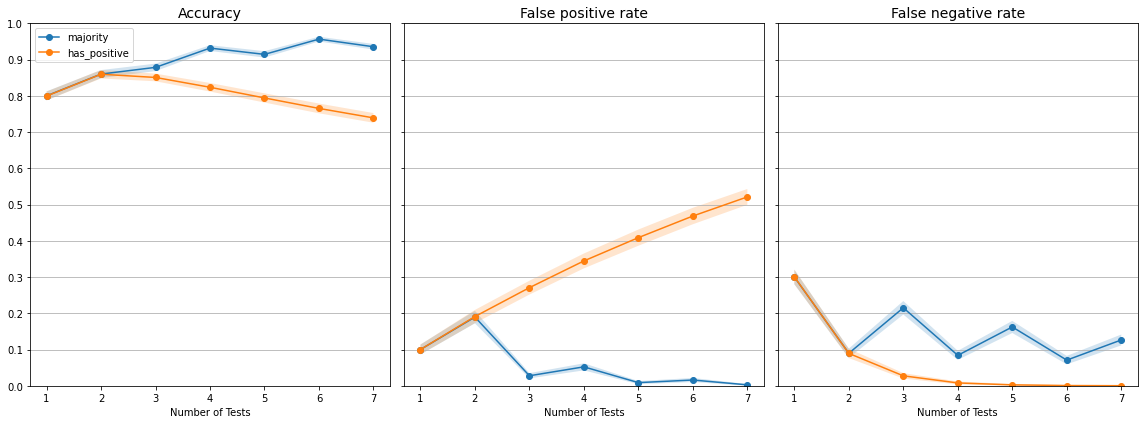

In [3]:
# Parameters
ir = 0.5
n = 1000
fnr = .3
fpr = .1

fig, ax = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
rvals = np.arange(1, 8, 1)

for j, rule in enumerate(['majority', 'has_positive']):
    acc__ = []
    fpr__ = []
    fnr__ = []
    
    for i in range(1000):
        sample = np.random.choice([False, True], size=(n,), p=[1-ir, ir])
        
        acc = []
        fpr_ = []
        fnr_ = []
        
        for r in rvals:
            result = test(sample, fnr, fpr, r=r, rule=rule)
            acc.append((result==sample).mean())
            fpr_.append(result[np.where(sample==False)[0]].mean())
            fnr_.append(1-result[np.where(sample==True)[0]].mean())
        acc__.append(acc)
        fpr__.append(fpr_)
        fnr__.append(fnr_)

    acc_mean = np.mean(acc__, axis=0)
    acc_std = np.array(acc__).std(axis=0)
    fpr_mean = np.mean(fpr__, axis=0)
    fpr_std = np.array(fpr__).std(axis=0)
    fnr_mean = np.mean(fnr__, axis=0)
    fnr_std = np.array(fnr__).std(axis=0)

    metrics = ['accuracy', 'false positive rate', 'false negative rate']
    mean_values = [acc_mean, fpr_mean, fnr_mean]
    std_values = [acc_std, fpr_std, fnr_std]
    
    for k, metric in enumerate(metrics):
        ax_ = ax[k]
        ax_.plot(rvals, mean_values[k], label=rule, marker='o')
        ax_.fill_between(rvals, y1=mean_values[k]-std_values[k],
                         y2=mean_values[k]+std_values[k], alpha=.2)
        ax_.set_ylim(0, 1)
        ax_.set_xticks(rvals)
        ax_.set_yticks(np.arange(11)/10)
        ax_.set_title(f'{metric.capitalize()}', size=14)
        ax_.set_xlabel('Number of Tests')
        if k==0:
            ax_.legend()
            
ax[0].grid(axis='y')
ax[1].grid(axis='y')
ax[2].grid(axis='y')

fig.tight_layout();

### Observations

As expected, when only two repetitions are performed, both decision rules arrive at the same value. We note that by performing at least one repetition, we increase accuracy and false positive rate while reducing false negative rate.

When using the majority rule, the accuracy tend to increase in general while both false positive and false negative rates tend to decrease but oscilates for odd values. 

On the otherhand, accuracy of the the has_positive rule may decrease with more repetitions. This is primarily due to the corresponding monotonic increase in the false positive rate. Additionally, the false negative rate is monotonically decreasing.

#### Recommendation
Since false negative rate is more important than both accuracy and false positive rate, **we recommend to use the has positive rule when testing** as it leads to lower false negative rates faster compared to the majority rule.

## Testing Strategies

In this section, we write the code for the different testing strategies that we want to compare.

In [4]:
def test_pool(pool, fnr=0, fpr=0, r=1, rule='has_positive'):
    has_positive = np.array([np.any(pool)])
    result = test(has_positive, fnr, fpr, r, rule)[0]
    return result

### Linear Search
This is the currently implemented approach where for *N* individuals that needs to be tested, we perform *Nr* tests where r is the number of replicate tests.

In [5]:
def linear_search(samples, fnr=0, fpr=0, r=1, rule='has_positive'):
    """
    Check samples from each person individually.
    """
    results = test(samples, fnr, fpr, r, rule)
    ntests = len(samples)*r
    return results, ntests

### Dorfman Pooled Test
This is the simplest pooling strategy wherein we combine collected samples from *m* individuals into a single pooled sample. If the sample turned out negative, then all the individuals from the pool are negative. Otherwise, each individuals will be tested independently. 

This method has been first introduced by Robert Dorfman in 1943 (see paper [here](https://projecteuclid.org/euclid.aoms/1177731363)) and recently by Hanel and Thurner (see [arxiv paper](https://arxiv.org/pdf/2003.09944.pdf)) to further improve testing efficiency at at the Rambam
Medical Center and the Technion in Haifa, Israel (see [article](https://www.technion.ac.il/en/2020/03/pooling-method-for-accelerated-testing-of-covid-19/) from Technion Istrael Institute of Technology).

In [6]:
def one_vs_all_search(pool, fnr=0, fpr=0, r=1,
                      rule='has_positive'):
    ntests = r
    result = test_pool(pool, fnr, fpr, r, rule)
    if result == False:
        results = np.array([False]*len(pool))
    else:
        results, ntests_ = linear_search(pool, fnr, fpr, r, rule)
        ntests += ntests_
    return results, ntests

### Binary Search

**Version 1**  
1. We begin with a pooled sample with size m. 
2. If the sample is negative, then the m individuals are negative. 
3. Else, we split the individuals into two and then retest each subsample. 
4. We repeat this until all individuals have been labeled as negative or positive.

**Version 2**  
For version two, we make a tweak from step 3.

Modified Step 3: Split individuals into two samples. If the first of two subsamples is negative, then the second subsample must have the positive sample. Thus, the second subsample can be split directly without performing another test.

In [7]:
def binary_search(pool, fnr=0, fpr=0, r=1, test_left=True, rule='has_positive'):
    total_tests = 0

    if len(pool) == 0:
        return np.array([]), 0

    elif len(pool) == 1:
        if test_left:
            result = test_pool(pool, fnr, fpr, r, rule=rule)
            return np.array([result]), r
        else:
            return np.array([True]), 0

    else:
        if test_left:
            result = test_pool(pool, fnr, fpr, r, rule=rule)
            total_tests += r
        else:
            result = True

        # if pool is negative, the all samples are negative
        if result == False:
            return np.array([False]*len(pool)), total_tests
        else:
            # perform right search first strategy
            rstart = len(pool) // 2
            rresult, rtests = binary_search(pool[rstart:], r=r)
            
            if np.any(rresult):
                lresult, ltests = binary_search(pool[:rstart], fnr, fpr,
                                                r, rule=rule)
            else:
                lresult, ltests = binary_search(pool[:rstart], fnr, fpr,
                                                r, test_left=False, rule=rule)

            results = np.concatenate([lresult, rresult])
            total_tests += (ltests + rtests)
            return results, total_tests

### Square Array Pooling

This method was introduced by Westreich et. all ([pubmed link](https://www.ncbi.nlm.nih.gov/pubmed/18353930/)) and was used by Bharti et al. to study pooled diagnosis of Malaria (see paper [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2770880/#R16)). The image below taken from the same paper shows how the procedure was performed.

<img src="../img/square_array.png" alt="Drawing" style="width: 600px;"/>

In [8]:
def squared_array(pool, fnr=0, fpr=0, r=1, rule='has_positive'):
    # create squared array
    size = int(np.sqrt(len(pool)))
    rowsize, colsize = size, size
    pool_square = pool.reshape(rowsize, colsize)
    
    # set initial values for results
    results = np.full_like(pool_square, False)

    # test row and column pools
    row_test = np.array([test_pool(pool_square[row], fnr, fpr, r) for row in range(rowsize)])
    col_test = np.array([test_pool(pool_square[:, col], fnr, fpr, r) for col in range(colsize)])

    # determine samples to test independently
    cross_test_result = np.outer(row_test, col_test)
    ind = np.where(cross_test_result)

    # perform independent testing and update results
    results[ind] = np.array([test_pool(sample, fnr, fpr, r) for sample in pool_square[ind]])

    # reshape results
    results = results.reshape(len(pool))
    
    total_tests = rowsize + colsize + len(ind[0])
    
    return results, total_tests

## Simulations

In [9]:
def pooled_testing(pool, pool_size, fnr=0, fpr=0, r=1,
                   rule='has_positive', strategy=None):
    results = []
    ntests = 0
    for i in range(int(np.ceil(len(samples) / pool_size))):
        pool = samples[pool_size*i: pool_size*(i+1)]
        if strategy == 'one_vs_all':
            presult, ptests = one_vs_all_search(pool, fnr, fpr, r, rule)
        elif strategy == 'binary_search':
            presult, ptests = binary_search(pool, fnr, fpr, r, rule)
        elif strategy == 'squared_array':
            sqrt = np.sqrt(len(pool))
            if sqrt != int(sqrt):
                presult, ptests = linear_search(pool, fnr, fpr, r, rule)
            else:
                presult, ptests = squared_array(pool, fnr, fpr, r, rule)
        else: # perform linear search
            presult, ptests = linear_search(pool, fnr, fpr, r, rule)
            
        results.append(presult)
        ntests += ptests
    return np.concatenate(results), ntests

### One Vs All Search

In [12]:
# Simulation Parameters
n = 50000 # number of individuals to be tested
fpr = 0.1 # false positive rate
fnr = 0.3 # false negative rate
r = 1 # replicates of pooled sample
rule = 'has_positive'

infection_rates = [.1, 1, 5, 10, 15, 20, 30, 40, 50, 60]
accs = []
fprs = []
fnrs = []
tpps = []
pool_sizes = 2**np.arange(1, 7)
for ir in infection_rates:
    # generate samples
    samples = np.random.choice([False, True], size=n, p=[1-ir/100, ir/100])
    
    accs_ = []
    fprs_ = []
    fnrs_ = []
    tpps_ = []
    for pool_size in pool_sizes:
        results, ntests = pooled_testing(samples, pool_size=pool_size, fnr=fnr, r=2,
                                         fpr=fpr, strategy='one_vs_all', rule=rule)
        acc = (results==samples).mean()      
        
        fp = results[np.where(samples==False)[0]]
        fpr_ = 0 if len(fp)==0 else fp.mean()
    
        tp = results[np.where(samples==True)[0]]
        fnr_ = 0 if len(tp)==0 else 1-tp.mean()
        
        accs_.append(acc)
        fprs_.append(fpr_)
        fnrs_.append(fnr_)
        tpps_.append(n/ntests)

    accs.append(accs_)
    fprs.append(fprs_)
    fnrs.append(fnrs_)
    tpps.append(tpps_)
    
accs = np.array(accs).T
fprs = np.array(fprs).T
fnrs = np.array(fnrs).T
tpps = np.array(tpps).T

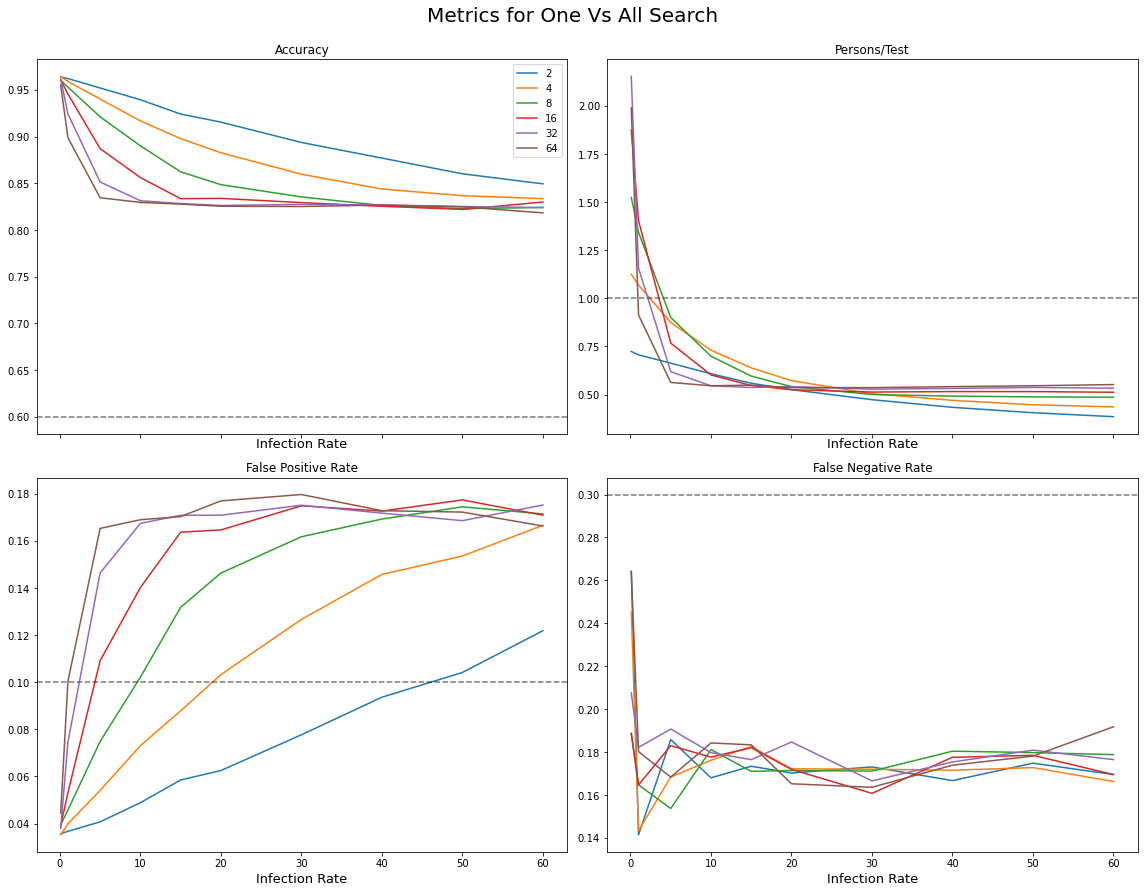

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12), sharex=True)
for i, psize in enumerate(pool_sizes):
    accuracy = accs[i]
    ax[0,0].plot(infection_rates, accuracy, label=psize)
    ax[0,0].legend()
    ax[0,0].set_xlabel('Infection Rate', fontsize=13)
    ax[0,0].set_title('Accuracy')
    ax[0,0].axhline(1-fnr-fpr, linestyle='--', color='k', alpha=.1)
    
    tests_per_person = tpps[i]
    ax[0,1].plot(infection_rates, tests_per_person, label=psize)
    ax[0,1].set_xlabel('Infection Rate', fontsize=13)
    ax[0,1].set_title('Persons/Test')
    ax[0,1].axhline(1, linestyle='--', color='k', alpha=.1)
    
    fprate = fprs[i]
    ax[1,0].plot(infection_rates, fprate, label=psize)
    ax[1,0].set_xlabel('Infection Rate', fontsize=13)
    ax[1,0].axhline(fpr, linestyle='--', color='k', alpha=.1)
    ax[1,0].set_title('False Positive Rate')

    fnrate = fnrs[i]
    ax[1,1].plot(infection_rates, fnrate, label=psize)
    ax[1,1].set_xlabel('Infection Rate', fontsize=13)
    ax[1,1].axhline(fnr, linestyle='--', color='k', alpha=.1)
    ax[1,1].set_title('False Negative Rate')

fig.suptitle('Metrics for One Vs All Search', fontsize=20, y=1.03)
fig.tight_layout()

### Square Array Search

In [17]:
# Simulation Parameters
n = 50000 # number of individuals to be tested
fpr = 0.1 # false positive rate
fnr = 0.3 # false negative rate
r = 1 # replicates of pooled sample
rule = 'has_positive'

infection_rates = [.1, 1, 5, 10, 15, 20, 30, 40, 50, 60]
accs = []
fprs = []
fnrs = []
tpps = []
# psizes = []
pool_sizes = 2**np.arange(1, 7)
for ir in infection_rates:
    # generate samples
    samples = np.random.choice([False, True], size=n, p=[1-ir/100, ir/100])
    
    accs_ = []
    fprs_ = []
    fnrs_ = []
    tpps_ = []
    for pool_size in pool_sizes:
        results, ntests = pooled_testing(samples, pool_size=pool_size, fnr=fnr, r=2,
                                         fpr=fpr, strategy='squared_array', rule=rule)
        acc = (results==samples).mean()      
        
        fp = results[np.where(samples==False)[0]]
        fpr_ = 0 if len(fp)==0 else fp.mean()
    
        tp = results[np.where(samples==True)[0]]
        fnr_ = 0 if len(tp)==0 else 1-tp.mean()
        
        accs_.append(acc)
        fprs_.append(fpr_)
        fnrs_.append(fnr_)
        tpps_.append(n/ntests)

    accs.append(accs_)
    fprs.append(fprs_)
    fnrs.append(fnrs_)
    tpps.append(tpps_)
    
accs = np.array(accs).T
fprs = np.array(fprs).T
fnrs = np.array(fnrs).T
tpps = np.array(tpps).T

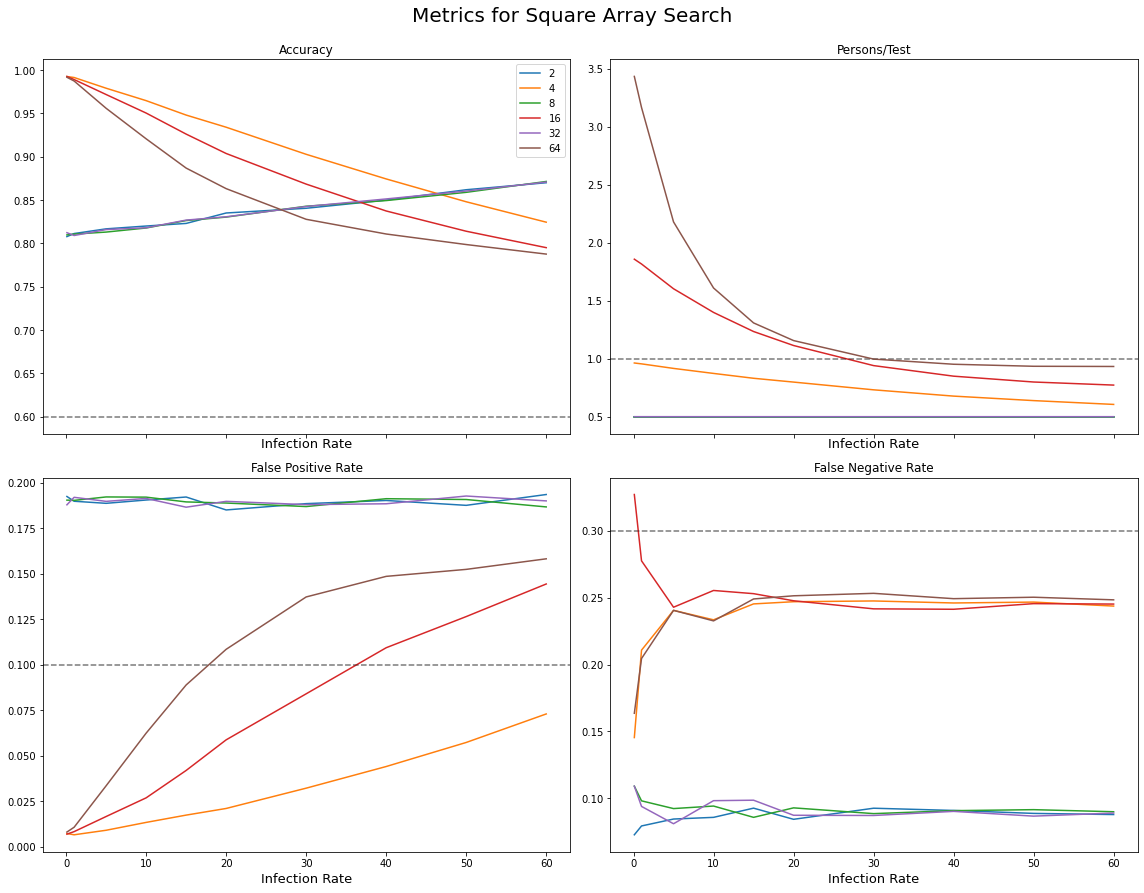

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12), sharex=True)
for i, psize in enumerate(pool_sizes):
    accuracy = accs[i]
    ax[0,0].plot(infection_rates, accuracy, label=psize)
    ax[0,0].legend()
    ax[0,0].set_xlabel('Infection Rate', fontsize=13)
    ax[0,0].set_title('Accuracy')
    ax[0,0].axhline(1-fnr-fpr, linestyle='--', color='k', alpha=.1)
    
    tests_per_person = tpps[i]
    ax[0,1].plot(infection_rates, tests_per_person, label=psize)
    ax[0,1].set_xlabel('Infection Rate', fontsize=13)
    ax[0,1].set_title('Persons/Test')
    ax[0,1].axhline(1, linestyle='--', color='k', alpha=.1)
    
    fprate = fprs[i]
    ax[1,0].plot(infection_rates, fprate, label=psize)
    ax[1,0].set_xlabel('Infection Rate', fontsize=13)
    ax[1,0].axhline(fpr, linestyle='--', color='k', alpha=.1)
    ax[1,0].set_title('False Positive Rate')

    fnrate = fnrs[i]
    ax[1,1].plot(infection_rates, fnrate, label=psize)
    ax[1,1].set_xlabel('Infection Rate', fontsize=13)
    ax[1,1].axhline(fnr, linestyle='--', color='k', alpha=.1)
    ax[1,1].set_title('False Negative Rate')

fig.suptitle('Metrics for Square Array Search', fontsize=20, y=1.03)
fig.tight_layout()

**Observation**  
The squared array method is effective when infection rate is lower than 30%.

### Binary Search

In [10]:
# Simulation Parameters
n = 50000 # number of individuals to be tested
fpr = 0.1 # false positive rate
fnr = 0.3 # false negative rate
r = 1 # replicates of pooled sample
rule = 'has_positive'

infection_rates = [.1, 1, 5, 10, 15, 20, 30, 40, 50, 60]
accs = []
fprs = []
fnrs = []
tpps = []
# psizes = []
pool_sizes = 2**np.arange(1, 7)
for ir in infection_rates:
    # generate samples
    samples = np.random.choice([False, True], size=n, p=[1-ir/100, ir/100])
    
    accs_ = []
    fprs_ = []
    fnrs_ = []
    tpps_ = []
    for pool_size in pool_sizes:
        results, ntests = pooled_testing(samples, pool_size=pool_size, fnr=fnr, r=2,
                                         fpr=fpr, strategy='binary_search', rule=rule)
        acc = (results==samples).mean()      
        
        fp = results[np.where(samples==False)[0]]
        fpr_ = 0 if len(fp)==0 else fp.mean()
    
        tp = results[np.where(samples==True)[0]]
        fnr_ = 0 if len(tp)==0 else 1-tp.mean()
        
        accs_.append(acc)
        fprs_.append(fpr_)
        fnrs_.append(fnr_)
        tpps_.append(n/ntests)

    accs.append(accs_)
    fprs.append(fprs_)
    fnrs.append(fnrs_)
    tpps.append(tpps_)
    
accs = np.array(accs).T
fprs = np.array(fprs).T
fnrs = np.array(fnrs).T
tpps = np.array(tpps).T

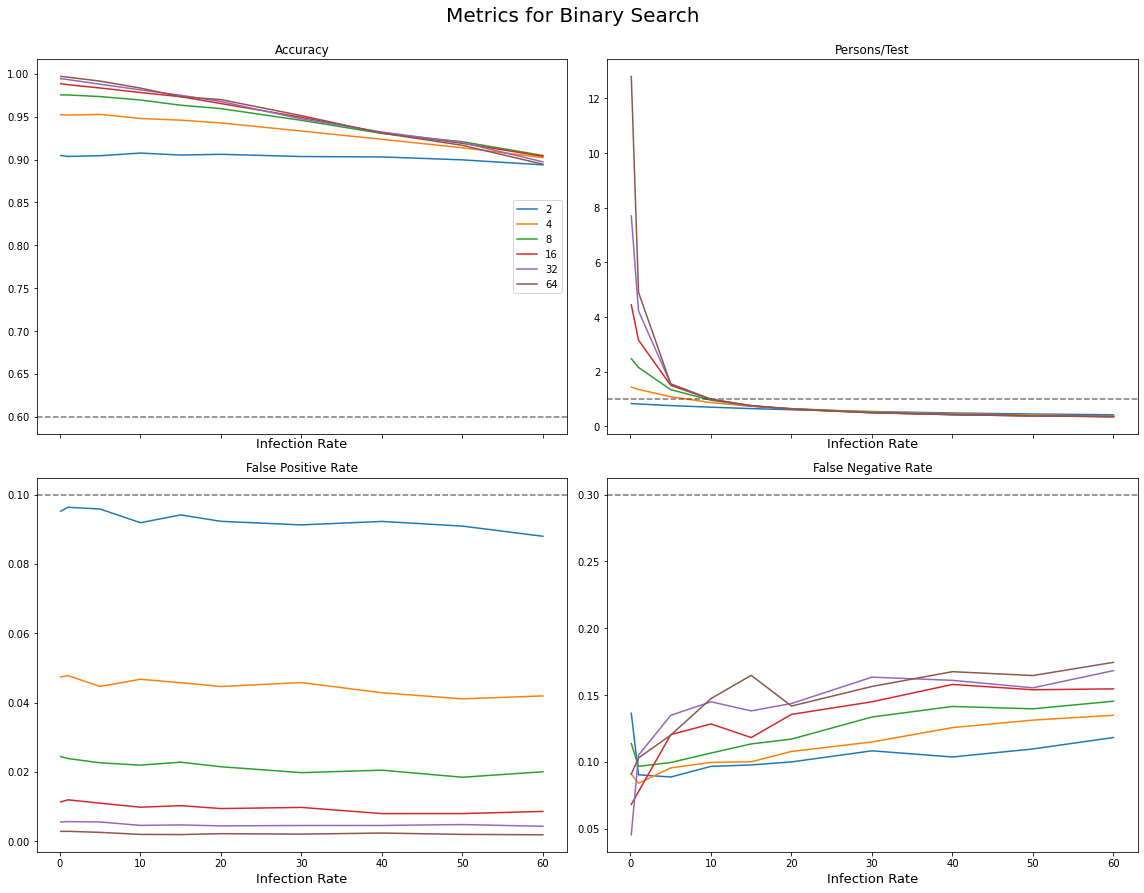

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12), sharex=True)
for i, psize in enumerate(pool_sizes):
    accuracy = accs[i]
    ax[0,0].plot(infection_rates, accuracy, label=psize)
    ax[0,0].legend()
    ax[0,0].set_xlabel('Infection Rate', fontsize=13)
    ax[0,0].set_title('Accuracy')
    ax[0,0].axhline(1-fnr-fpr, linestyle='--', color='k', alpha=.1)
    
    tests_per_person = tpps[i]
    ax[0,1].plot(infection_rates, tests_per_person, label=psize)
    ax[0,1].set_xlabel('Infection Rate', fontsize=13)
    ax[0,1].set_title('Persons/Test')
    ax[0,1].axhline(1, linestyle='--', color='k', alpha=.1)
    
    fprate = fprs[i]
    ax[1,0].plot(infection_rates, fprate, label=psize)
    ax[1,0].set_xlabel('Infection Rate', fontsize=13)
    ax[1,0].axhline(fpr, linestyle='--', color='k', alpha=.1)
    ax[1,0].set_title('False Positive Rate')

    fnrate = fnrs[i]
    ax[1,1].plot(infection_rates, fnrate, label=psize)
    ax[1,1].set_xlabel('Infection Rate', fontsize=13)
    ax[1,1].axhline(fnr, linestyle='--', color='k', alpha=.1)
    ax[1,1].set_title('False Negative Rate')

fig.suptitle('Metrics for Binary Search', fontsize=20, y=1.03)
fig.tight_layout()

**Observations**  
In the simulation above, determine various metrics based on difference infection rate values. To insure that the false negative rate is lower than the given, we set the repetition *r=2*. This results in the reduction of the *Persons/Test* metric. With this, the binary search algorithm will only be advantageous compared to regular testing when the infection rate is less than 10% and the effectivity increases exponentially when the infection rate is very low.

TO DO:

1. change testing in has positive such that if first test is positive, then test is already positive without doing multiple tests. This should reduce number of test repetitions.
2. modify square array to rectangular array